### Song based sentiment analysis using Textblob

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim import matutils, models

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

from pprint import pprint

In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/cleanedData.csv')

## Get a balanced sample of n songs per genre

In [25]:
num_genres = song_data.Genre.nunique()
num_topics = num_genres
genres = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock']
topic_columns = [i for i in range(0, num_topics)]
label_lookup = {
    0: "Country",
    1: "Electronic",
    2: "Folk",
    3: "Hip-Hop",
    4: "Indie",
    5: "Jazz",
    6: "Metal",
    7: "Pop",
    8: "R&B",
    9: "Rock"
}

In [4]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(1000).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,"She took my love, She wore it down And it look..."
1,Country,(Porter Wagoner) He walks in my mind like a sh...
2,Country,"Well, you told me when we met Your love would ..."
3,Country,I wish you only knew all the days I've made it...
4,Country,"It was warm, now its cold. It was young,, now ..."
5,Country,Sometimes I want to throw my arms around you T...
6,Country,I have seen the morning burning golden on the ...
7,Country,Love Is A Never Ending War (D. Blackwell) Well...
8,Country,"Hush, little darling, celebrate Today's gonna ..."
9,Country,Longneck bottle Let go of my hand Hey jukebox ...


## Remove punctuation/lower casing

In [5]:
song_data_processed = song_data.copy()
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: x.lower())

## Sentiment Analysis

In [6]:
song_data_processed['Sentiment'] = song_data_processed['Lyrics'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
song_data_processed['Subjectivity'] = song_data_processed['Lyrics'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

In [7]:
song_data_processed

,Genre,Lyrics,Sentiment,Subjectivity
0,Country,she took my love she wore it down and it looke...,0.232766,0.593084
1,Country,(porter wagoner) he walks in my mind like a sh...,0.080000,0.250000
2,Country,well you told me when we met your love would l...,0.097051,0.421478
3,Country,i wish you only knew all the days i've made it...,0.364286,0.619048
4,Country,it was warm now its cold it was young now its ...,0.086364,0.473214
...,...,...,...,...
9995,Rock,am i really hard to please\nperhaps i have suc...,0.044777,0.580376
9996,Rock,i saw the river playing in the valley\nrushin'...,-0.009380,0.503968
9997,Rock,falling\ni see you on the way down\ni'll meet ...,-0.097475,0.417172
9998,Rock,i don't know why i didn't see it before\ni don...,0.125000,0.525000


## LDA

### Remove stopwords and Tokenize

In [8]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


max_df: je niedriger dieser Wert, desto mehr Mainstream wörter, die in allen songs vorkommen, werden nicht beachtet

In [9]:
#Turn Lyrics into vectorized form (based on counts)
count_vec = CountVectorizer(stop_words=stop_words, max_df=0.2, min_df=0.01, ngram_range=(1,1))
words_df = count_vec.fit_transform(song_data_processed.Lyrics)

In [10]:
words_df = words_df.transpose()
corpus = matutils.Sparse2Corpus(words_df)
id2word = dict((v, k) for k, v in count_vec.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=100, random_state=11)

In [11]:
lda.print_topics(num_words=10)

[(0,
  '0.087*"baby" + 0.044*"girl" + 0.043*"wanna" + 0.035*"need" + 0.027*"tell" + 0.027*"give" + 0.020*"gotta" + 0.014*"hold" + 0.012*"gonna" + 0.011*"please"'),
 (1,
  '0.025*"things" + 0.025*"think" + 0.025*"good" + 0.022*"la" + 0.020*"something" + 0.017*"much" + 0.016*"look" + 0.016*"always" + 0.016*"would" + 0.015*"better"'),
 (2,
  '0.048*"night" + 0.022*"light" + 0.021*"sun" + 0.021*"blue" + 0.018*"eyes" + 0.018*"sky" + 0.017*"dream" + 0.015*"sweet" + 0.012*"moon" + 0.012*"fly"'),
 (3,
  '0.038*"nigga" + 0.031*"shit" + 0.029*"fuck" + 0.025*"money" + 0.024*"niggas" + 0.020*"bitch" + 0.019*"yo" + 0.015*"da" + 0.014*"ass" + 0.011*"gon"'),
 (4,
  '0.102*"gonna" + 0.057*"little" + 0.055*"tonight" + 0.047*"going" + 0.028*"turn" + 0.028*"alright" + 0.027*"ah" + 0.019*"fire" + 0.017*"ride" + 0.017*"round"'),
 (5,
  '0.024*"us" + 0.016*"die" + 0.016*"god" + 0.013*"nothing" + 0.013*"hate" + 0.012*"head" + 0.011*"hell" + 0.011*"fight" + 0.011*"save" + 0.011*"dead"'),
 (6,
  '0.016*"find" 

In [12]:
docTopicProbMat = lda[corpus]
csr = matutils.corpus2csc(docTopicProbMat)
doc_top = csr.T.toarray()
doc_top_df = pd.DataFrame(doc_top, columns = [i for i in range(0, num_topics)])
results = pd.merge(song_data_processed, doc_top_df, left_index=True, right_index=True)
results['Dominant_Topic'] = results[[i for i in range(0, num_topics)]].idxmax(axis=1)
results

,Genre,Lyrics,Sentiment,Subjectivity,0,1,2,3,4,5,6,7,8,9,Dominant_Topic
0,Country,she took my love she wore it down and it looke...,0.232766,0.593084,0.000000,0.000000,0.000000,0.420203,0.000000,0.000000,0.280426,0.000000,0.000000,0.277489,3
1,Country,(porter wagoner) he walks in my mind like a sh...,0.080000,0.250000,0.000000,0.563165,0.000000,0.000000,0.000000,0.000000,0.415775,0.000000,0.000000,0.000000,1
2,Country,well you told me when we met your love would l...,0.097051,0.421478,0.000000,0.000000,0.000000,0.000000,0.098310,0.000000,0.564287,0.128452,0.000000,0.201806,6
3,Country,i wish you only knew all the days i've made it...,0.364286,0.619048,0.000000,0.259153,0.515296,0.000000,0.040146,0.151255,0.000000,0.024147,0.000000,0.000000,2
4,Country,it was warm now its cold it was young now its ...,0.086364,0.473214,0.000000,0.570236,0.081808,0.000000,0.000000,0.000000,0.000000,0.000000,0.149780,0.182383,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Rock,am i really hard to please\nperhaps i have suc...,0.044777,0.580376,0.218733,0.174978,0.000000,0.000000,0.060199,0.000000,0.215334,0.000000,0.119700,0.205926,0
9996,Rock,i saw the river playing in the valley\nrushin'...,-0.009380,0.503968,0.000000,0.000000,0.022293,0.000000,0.023263,0.101264,0.000000,0.151188,0.220092,0.474880,9
9997,Rock,falling\ni see you on the way down\ni'll meet ...,-0.097475,0.417172,0.275413,0.000000,0.000000,0.000000,0.121395,0.199808,0.390337,0.000000,0.000000,0.000000,6
9998,Rock,i don't know why i didn't see it before\ni don...,0.125000,0.525000,0.000000,0.000000,0.495763,0.000000,0.000000,0.000000,0.477566,0.000000,0.000000,0.000000,2


### Explore the results

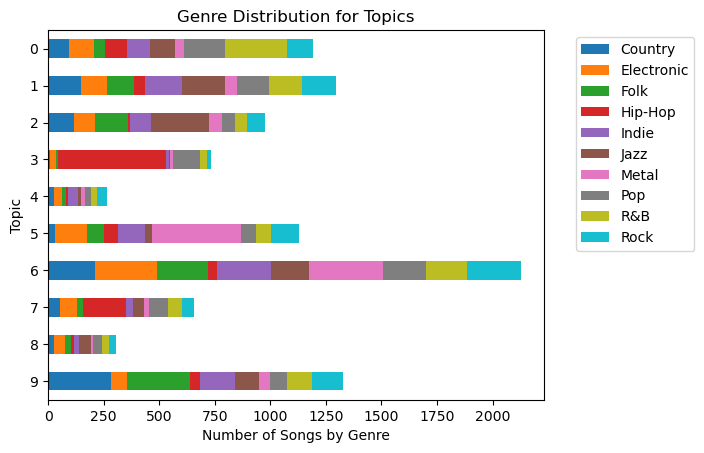

In [13]:
# Create a crosstab
crosstab = pd.crosstab(results['Dominant_Topic'], results['Genre']).sort_values(by="Dominant_Topic", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Genre Distribution for Topics')
plt.show()

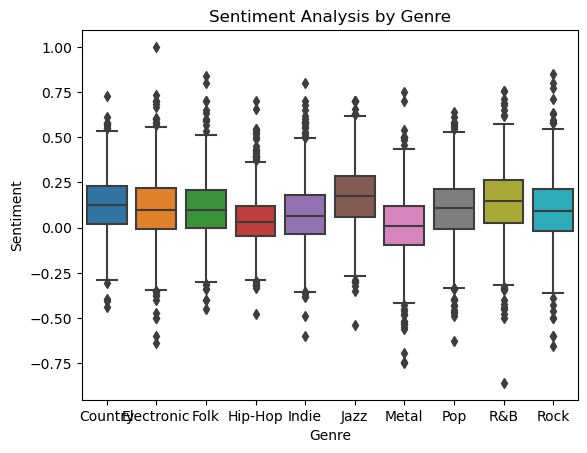

In [14]:
sns.boxplot(x='Genre', y='Sentiment', data=song_data_processed)
plt.title('Sentiment Analysis by Genre')
plt.show()

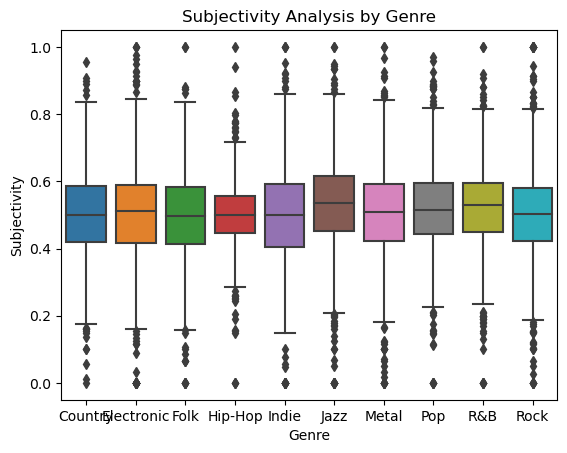

In [15]:
sns.boxplot(x='Genre', y='Subjectivity', data=song_data_processed)
plt.title('Subjectivity Analysis by Genre')
plt.show()

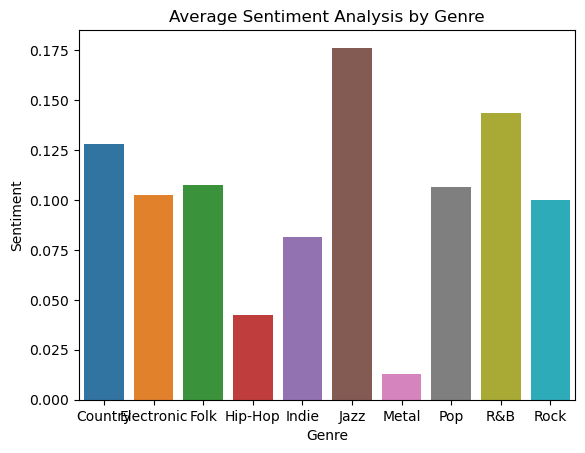

In [16]:
sns.barplot(x='Genre', y='Sentiment', data=song_data_processed, errorbar=None)
plt.title('Average Sentiment Analysis by Genre')
plt.show()

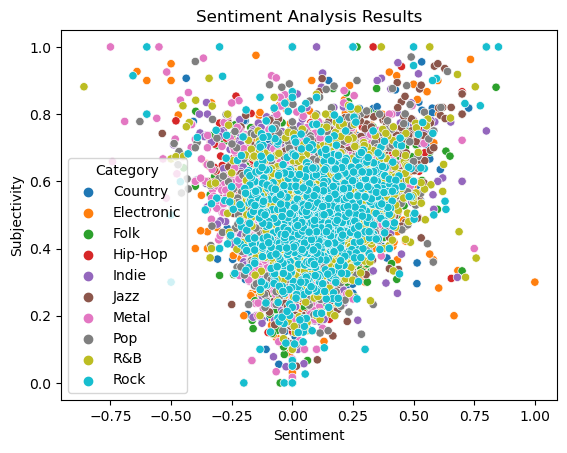

In [17]:
#Scatter Plot
sns.scatterplot(x='Sentiment', y='Subjectivity', hue='Genre', data=song_data_processed)
plt.title('Sentiment Analysis Results')
plt.legend(title='Category')
plt.show()

## Trying classification

In [18]:
results.columns = results.columns.astype(str)
X = results.iloc[:, 2:-1]
label_encoder = LabelEncoder()
song_data_processed["GenreID"] = label_encoder.fit_transform(song_data_processed["Genre"])
y = song_data_processed["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Index(['Sentiment', 'Subjectivity', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9'],
      dtype='object')

In [19]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.2673333333333333

In [20]:
#svm classifier
svc = SVC(kernel="rbf")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.3016666666666667

In [21]:
#Random forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.29

### Get Classification Matrix (of random forest)

In [22]:
y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.20      0.20      0.20       318
           1       0.22      0.17      0.19       308
           2       0.19      0.20      0.20       288
           3       0.56      0.69      0.62       303
           4       0.18      0.14      0.16       320
           5       0.36      0.43      0.39       290
           6       0.39      0.57      0.47       292
           7       0.16      0.10      0.12       292
           8       0.28      0.28      0.28       324
           9       0.13      0.12      0.13       265

    accuracy                           0.29      3000
   macro avg       0.27      0.29      0.27      3000
weighted avg       0.27      0.29      0.28      3000



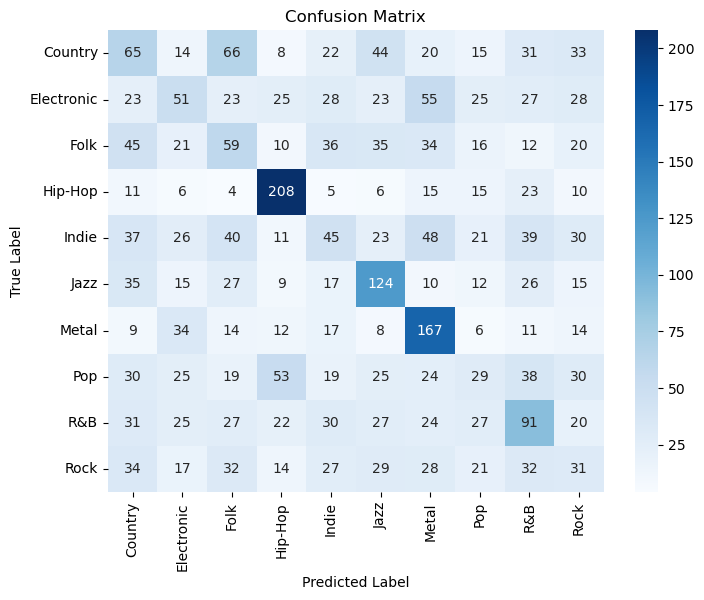

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = np.array([label_lookup.get(i) for i in svc.classes_])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
song_data_processed[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
1000,Electronic,1
2000,Folk,2
3000,Hip-Hop,3
4000,Indie,4
5000,Jazz,5
6000,Metal,6
7000,Pop,7
8000,R&B,8
9000,Rock,9


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Anwendung der sentiment analyse mithilfe der python textblob bibliothekt (Ergebnis in form von polarity & subjectivity)
- Anwendung von LDA auf die SongLyrics
- Investigating whether the combination of sentiment analysis and LDA can be better to predict a songs genre based on the lyrics than each method on its own

### Ergebnis
- Die Einzelergebnisse von sentiment analyse und LDA sind so wie in den anderen beiden Dokumenten
- Selbst bei der Kombination von sentiment analyse und LDA können die ML-Modelle das Genre eines Liedes nicht besser predicten. 
- Auch hier ist deutlich, dass HipHop songs die einzigen lieder sind, die relativ zuverlässig erkannt werden können
- Dabei weichen allerdings weder f1-score noch accuracy wesentlich ab von den einzelergebnissen der LDA
- Auch Metal songs können allerdings dabei etwas besser erkannt werden, was vermutlich durch die sentiment analyse verstärkt wird, da dieses Genre tendenziell negativer ist
- R&B hat auch leicht erhöhte werte, was daran liegen könnte, dass es bei der Topic Analyse / LDA in nur wenigen Topics vermehrt vorkommt
- Alles in allem ist die performance auf jeden Fall besser als bei der reinen Sentiment analyse
- Verglichen zur LDA ist die accuracy leicht niedriger, dafür gibt es einen besseren overall f1-score. Es gibt außerdem keine Genres mehr mit einem extrem niedrigen f1-score, so wie es bei der LDA mit Pop der Fall war. 
- insgesamt liegen die f1-scores der verschiedenen genres weniger weit auseinander
- der f1-score von HipHop ist noch höher als bei reiner LDA

### Interpretation
- All dies lässt die interpretation zu, dass man durch Kombination beider Ansätze (LDA und sentiment Analyse) tatsächlich eine leichte Verbesserung des Modells erreichen kann
